In [1]:
# TODO
# - add persistent participant ids once data is anonymized and rerun

In [2]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [3]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from scipy.interpolate import interp1d

from src.data.database_manager import DatabaseManager
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.log_config import configure_logging
from src.models.data_preparation import prepare_data
from src.models.main import RANDOM_SEED
from src.models.utils import get_device, load_model
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    create_aggregate_visualization,
    create_samples_full_stimulus,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


17:34:17 | INFO    | utils | Using device: mps
17:34:17 | INFO    | utils | Set seed to 42


In [4]:
config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
seeds = config["stimulus"]["seeds"]

In [5]:
device = get_device()
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic_heartrate_pupil_mean/model/PatchTST_20250429-141311.pt"
)


17:34:18 | INFO    | utils | Using device: mps
17:34:18 | INFO    | utils | Using device: mps
17:34:18 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77% to mps.
17:34:18 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_phasic', 'eda_tonic', 'heartrate', 'pupil_mean']


In [6]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

In [7]:
sample_duration_ms = 5000

# Get particpant IDs from test set
test_ids = prepare_data(
    df,
    features,
    sample_duration_ms,
    RANDOM_SEED,
    return_only_groups_for_test=True,
)
test_ids

array([ 7, 11, 17, 24, 30, 33, 36, 37, 48], dtype=uint8)

In [8]:
df.filter(participant_id=7)
df = df.filter(trial_id=320)

seed = df.get_column("stimulus_seed").unique().item()
seed

841

In [9]:
samples = create_samples_full_stimulus(df, features)


In [ ]:
stimulus_seed = 841

all_predictions, all_confidences, participant_trials = (
    analyze_test_dataset_for_one_stimulus(model, db, features, test_ids, stimulus_seed)
)


17:34:19 | INFO    | root | Inference on test dataset


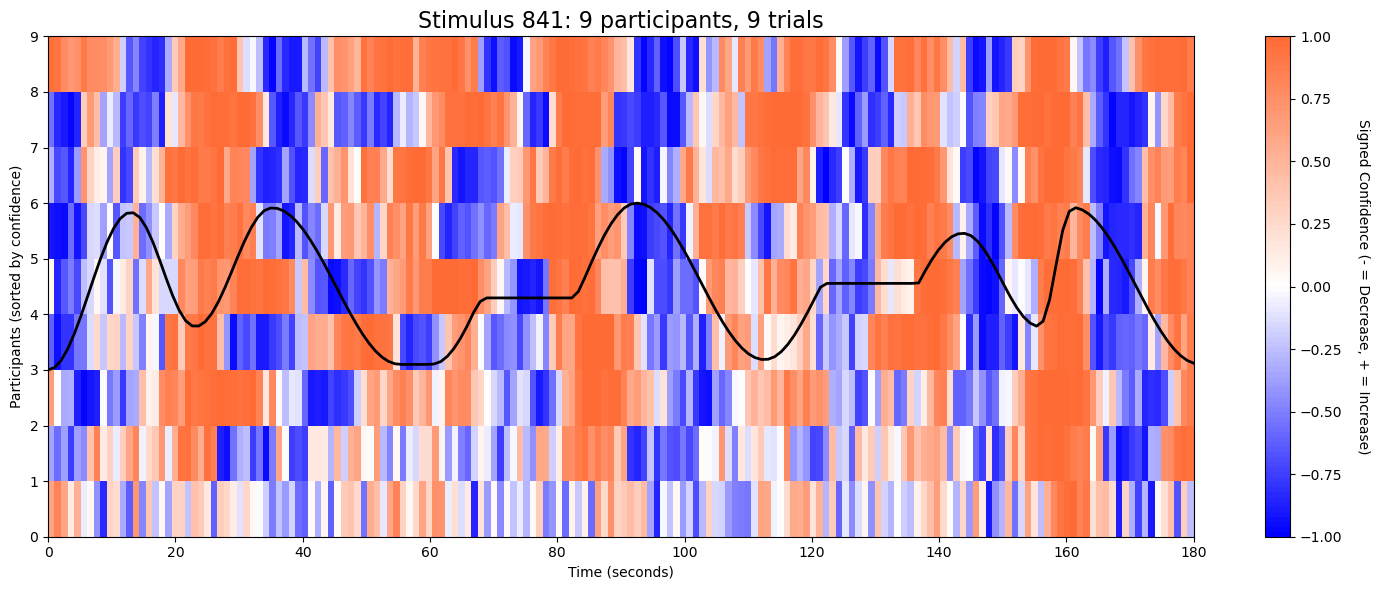

In [11]:
aggregate_fig = create_aggregate_visualization(
    all_predictions, all_confidences, stimulus_seed
)
plt.show()

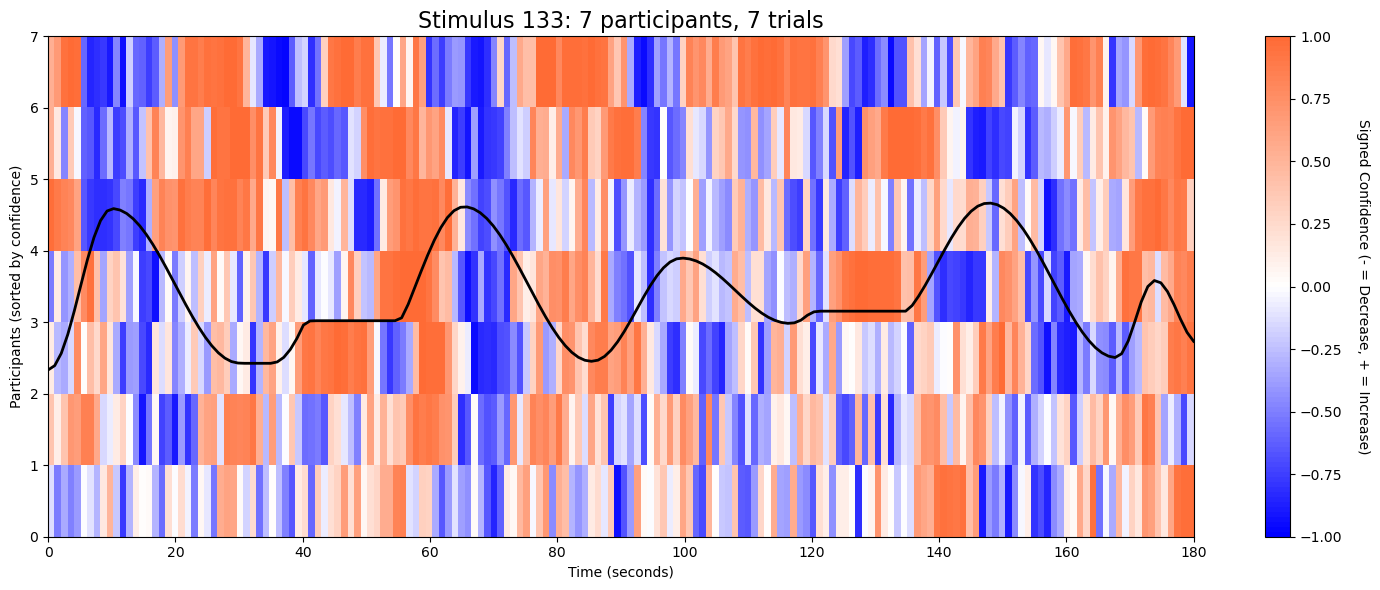

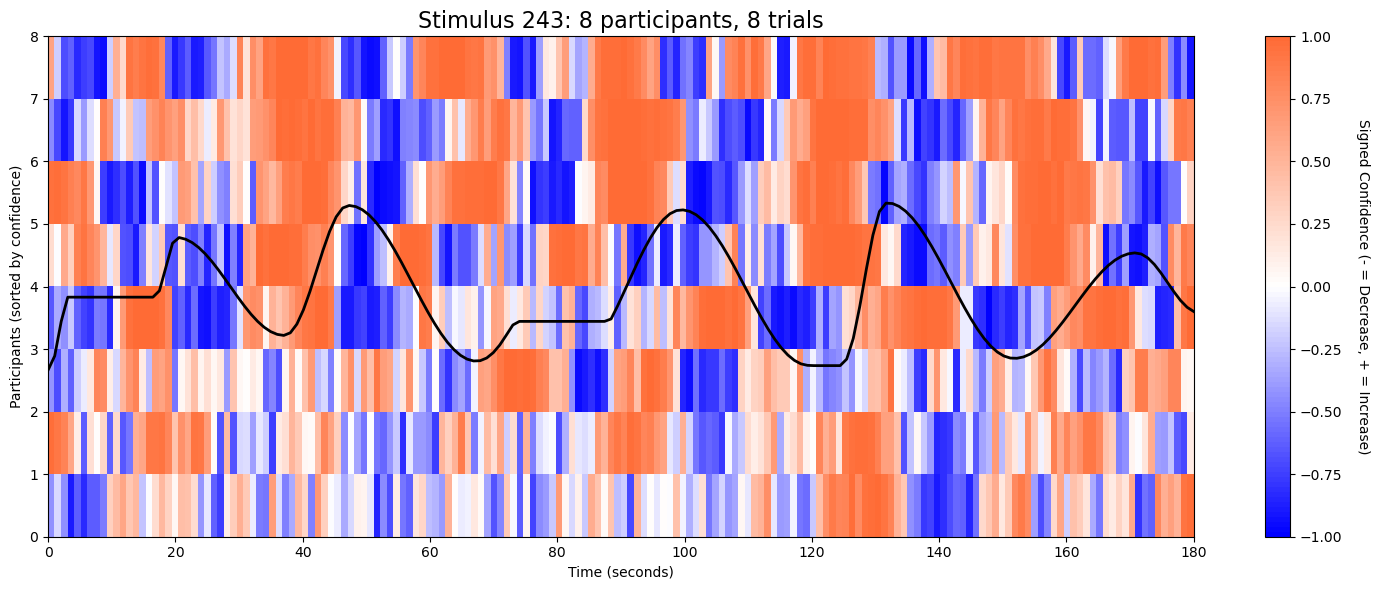

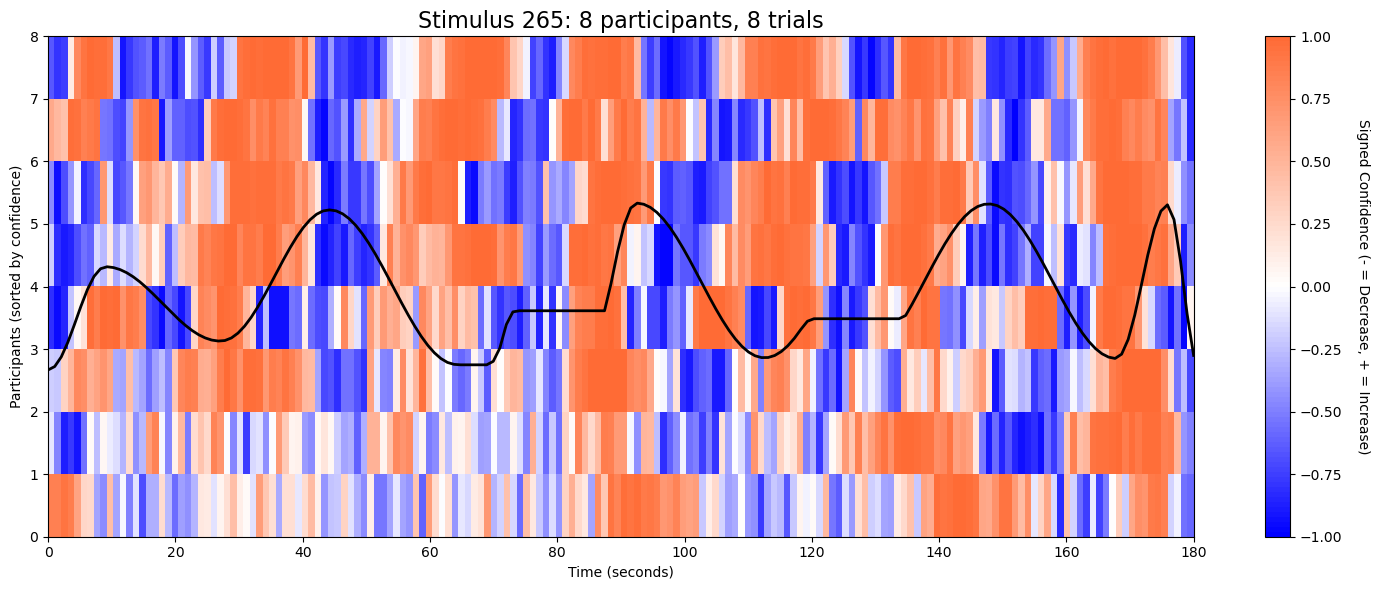

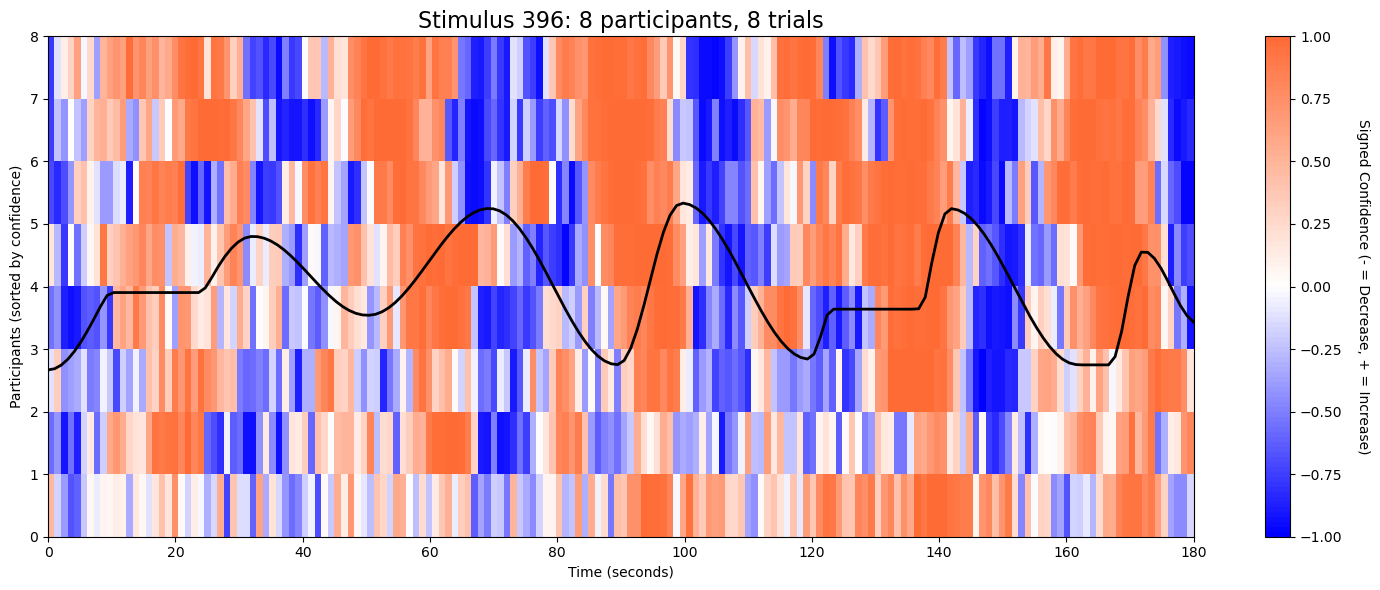

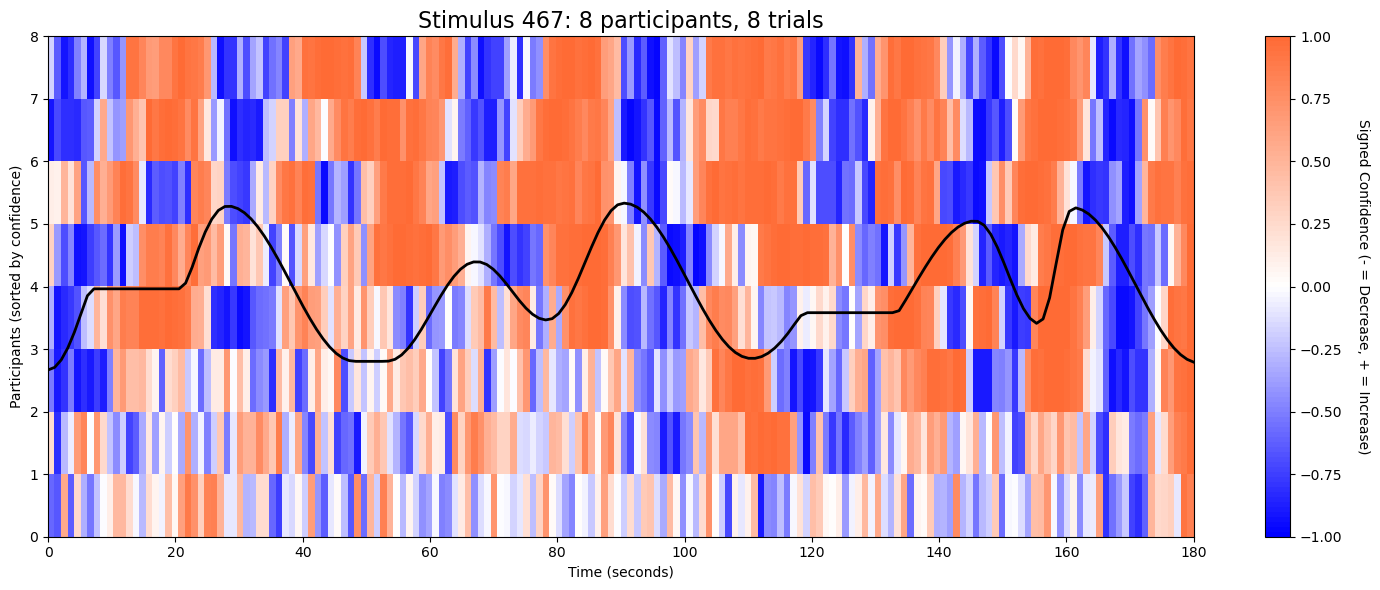

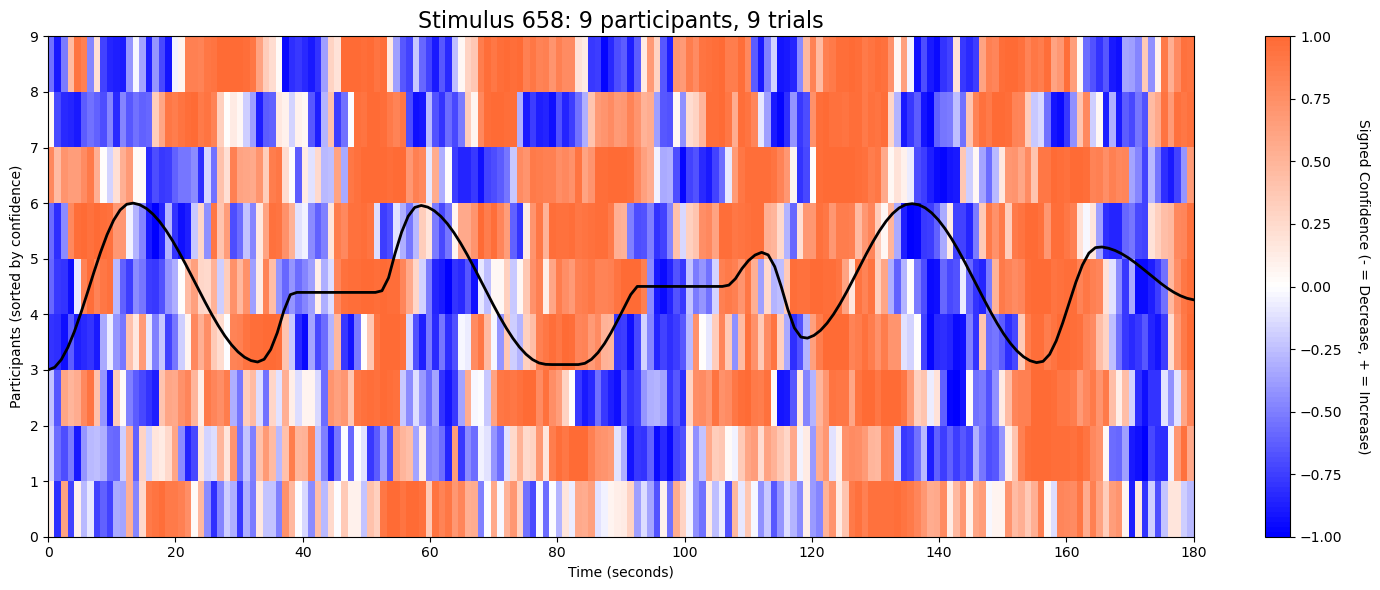

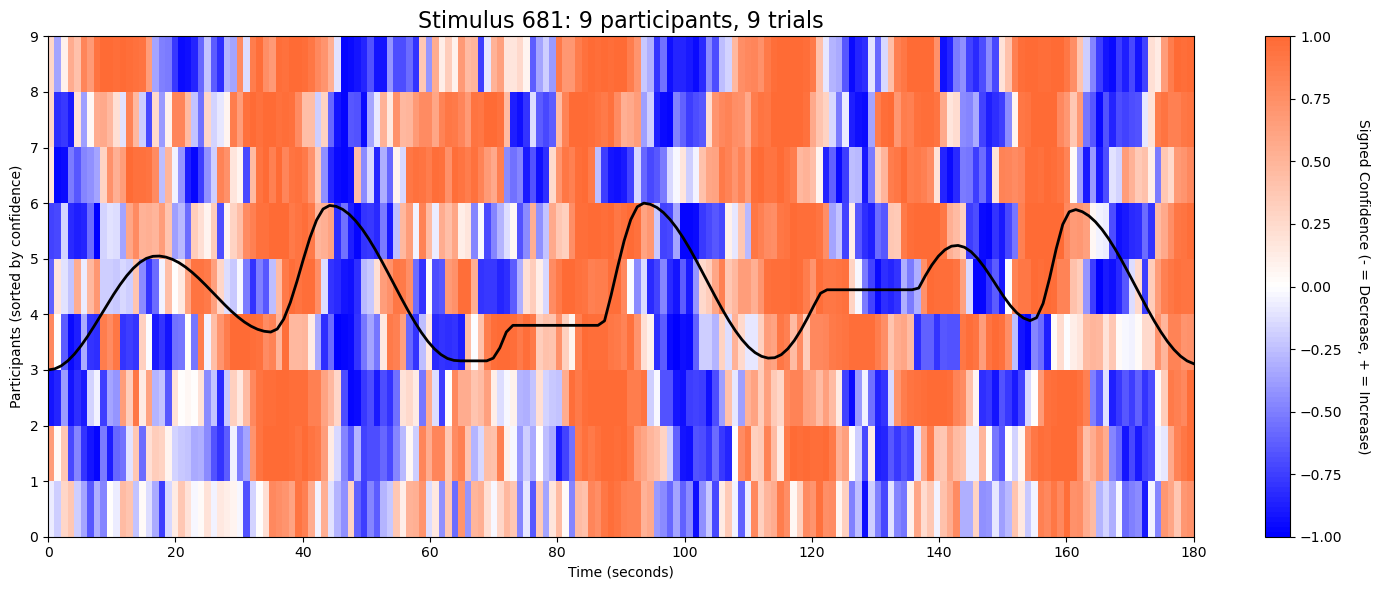

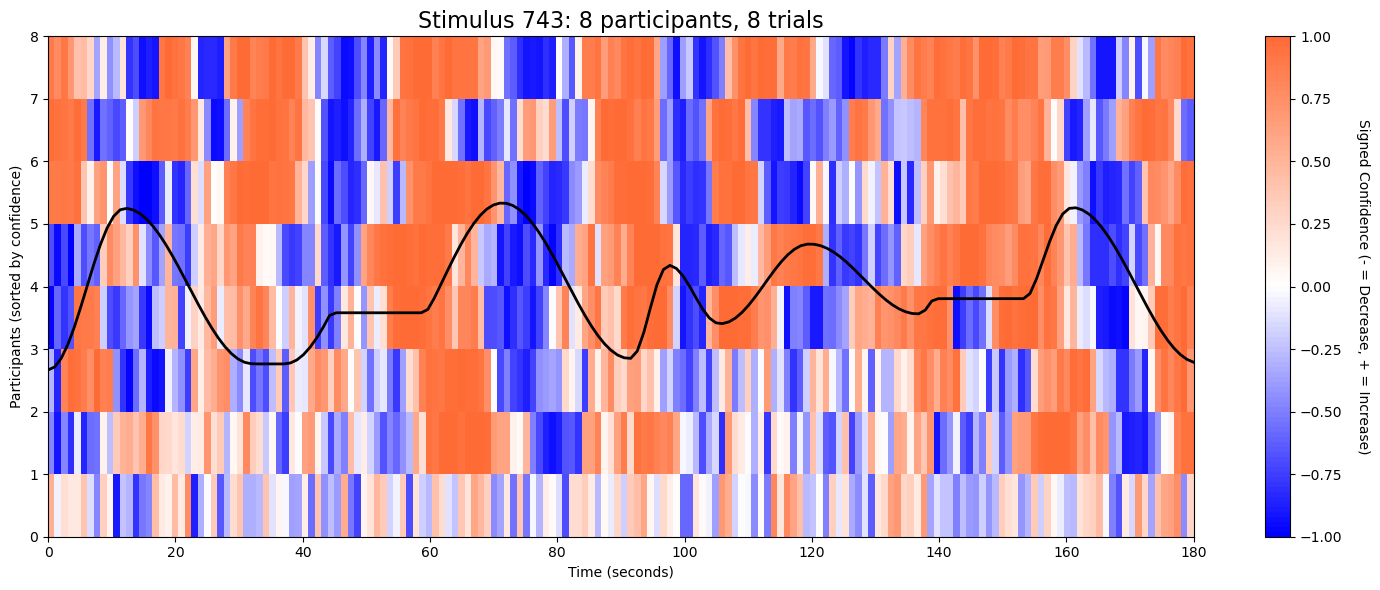

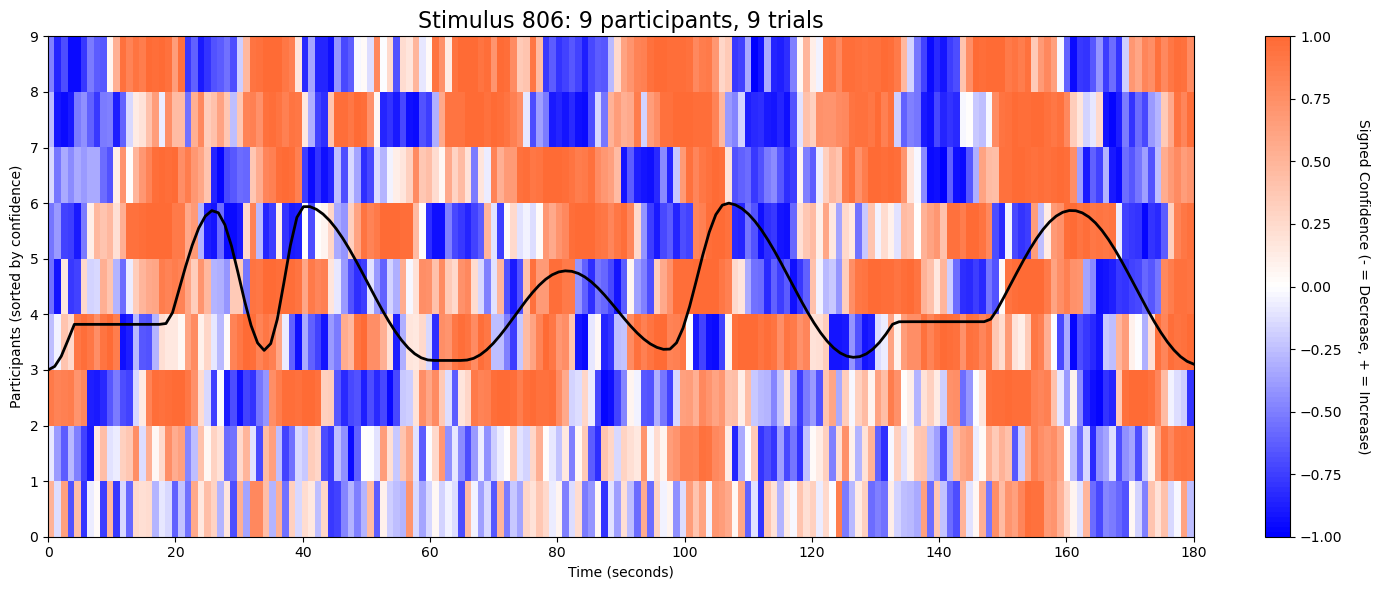

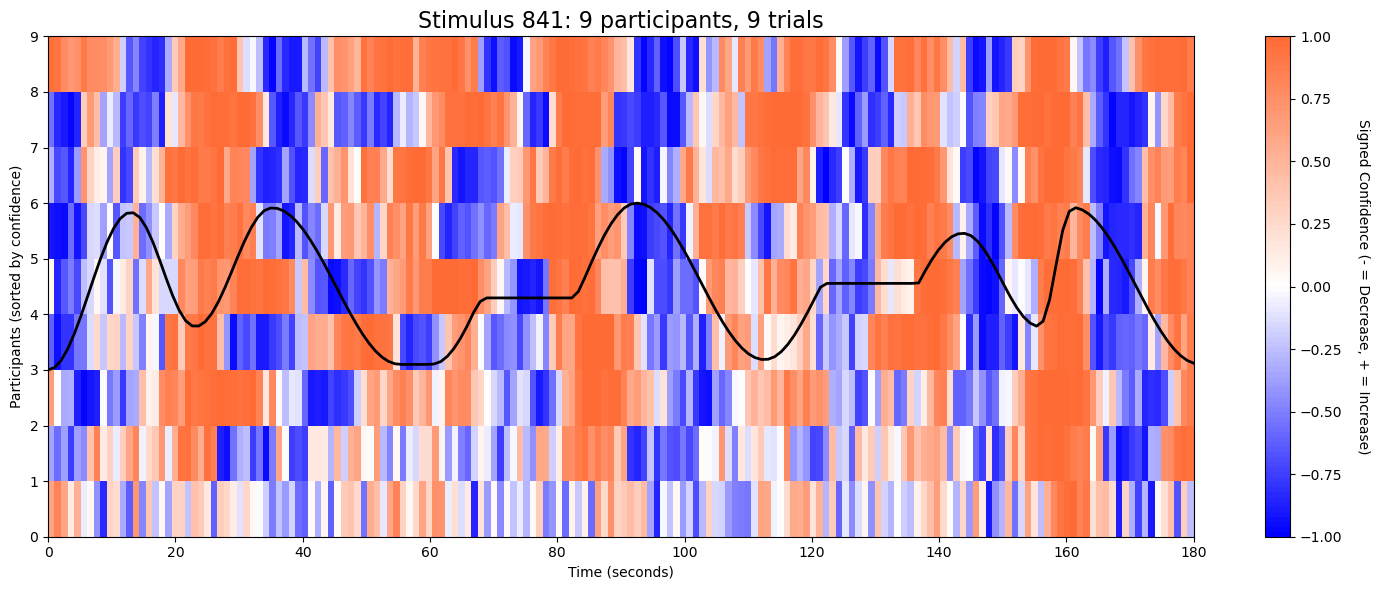

In [ ]:
for seed in seeds:
    # Analyze the entire test dataset
    all_predictions, all_confidences, participant_trials = (
        analyze_test_dataset_for_one_stimulus(
            model, db, features, test_ids, stimulus_seed=seed, logging=False
        )
    )

    # Create the visualization
    aggregate_fig = create_aggregate_visualization(
        all_predictions, all_confidences, stimulus_seed=seed
    )
    plt.show()

In [ ]:
# Alternative

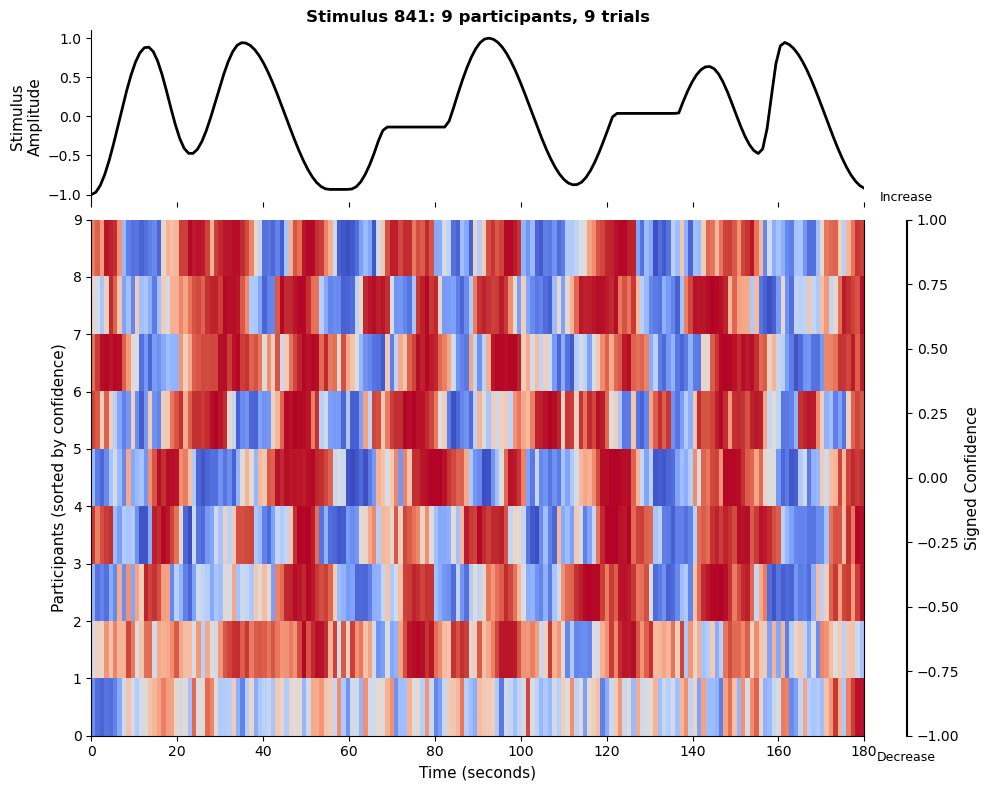

In [ ]:
from matplotlib.gridspec import GridSpec


def create_aggregate_visualization(
    aligned_predictions, aligned_confidences, stimulus_seed
):
    """
    Create a heatmap visualization of model predictions across all trials.
    Args:
        aligned_predictions: Dictionary of aligned predictions for each participant
        aligned_confidences: Dictionary of aligned confidences for each participant
        stimulus_seed: Seed used for the stimulus generation
    """
    # Create figure with two subplots using gridspec
    fig = plt.figure(figsize=(10, 8))
    # Create gridspec with proper spacing for colorbar
    gs = GridSpec(2, 20, figure=fig, height_ratios=[1, 3])

    # Main axes: stimulus on top, heatmap below
    ax_stim = fig.add_subplot(gs[0, :19])  # Use 19 of 20 columns
    ax_heat = fig.add_subplot(gs[1, :19], sharex=ax_stim)  # Share x-axis with stimulus
    ax_cbar = fig.add_subplot(gs[1, 19])  # Last column for colorbar

    # Combine all trials into a single matrix with signed confidences
    all_confidences_matrix = []

    for participant_id in aligned_confidences:
        for i, trial_confidences in enumerate(aligned_confidences[participant_id]):
            trial_predictions = aligned_predictions[participant_id][i]

            # Transform classifier confidences to centered, scaled values [-1, 1]
            signed_confidences = [
                -(conf - 0.5) * 2 if pred == 0 else (conf - 0.5) * 2
                for conf, pred in zip(trial_confidences, trial_predictions)
            ]
            all_confidences_matrix.append(signed_confidences)

    # Convert to numpy array and sort by average confidence
    confidence_array = np.array(all_confidences_matrix)
    avg_confidence = np.mean(np.abs(confidence_array), axis=1)
    sorted_indices = np.argsort(-avg_confidence)
    sorted_confidence_array = confidence_array[sorted_indices]

    # Create time axis
    time_points = np.linspace(0, 180, confidence_array.shape[1])

    # Get and process stimulus signal
    stim = StimulusGenerator(seed=stimulus_seed)
    stimulus = stim.y[::10]  # Downsample to match typical alignment length

    # Resample stimulus to match confidence array length
    f = interp1d(np.linspace(0, 1, len(stimulus)), stimulus)
    stimulus_resampled = f(np.linspace(0, 1, confidence_array.shape[1]))

    # Normalize stimulus to [-1, 1] for consistent display
    stimulus_norm = (
        2
        * (
            (stimulus_resampled - stimulus_resampled.min())
            / (stimulus_resampled.max() - stimulus_resampled.min())
        )
        - 1
    )

    # Plot the stimulus in the top panel
    ax_stim.plot(time_points, stimulus_norm, "k-", linewidth=2)
    ax_stim.set_xlim(0, 180)
    ax_stim.set_ylim(-1.1, 1.1)
    ax_stim.set_ylabel("Stimulus\nAmplitude", fontsize=11)
    ax_stim.set_title(
        f"Stimulus {stimulus_seed}: {len(aligned_confidences)} participants, {len(sorted_confidence_array)} trials",
        fontsize=12,
        fontweight="bold",
    )
    ax_stim.spines["top"].set_visible(False)
    ax_stim.spines["right"].set_visible(False)

    # Use a perceptually uniform diverging colormap (better for publication)
    cmap = plt.cm.coolwarm

    # Plot heatmap
    im = ax_heat.imshow(
        sorted_confidence_array,
        aspect="auto",
        cmap=cmap,
        vmin=-1,
        vmax=1,
        extent=(0, 180, 0, len(sorted_confidence_array)),
        interpolation="nearest",
    )

    # Add colorbar with improved formatting (in its own axis)
    cbar = plt.colorbar(im, cax=ax_cbar)
    cbar.set_label("Signed Confidence", fontsize=11)
    ax_cbar.text(
        0.5,
        -0.03,
        "Decrease",
        fontsize=9,
        ha="center",
        va="top",
        transform=ax_cbar.transAxes,
    )
    ax_cbar.text(
        0.5,
        1.03,
        "Increase",
        fontsize=9,
        ha="center",
        va="bottom",
        transform=ax_cbar.transAxes,
    )

    # Add labels with improved typography
    ax_heat.set_xlabel("Time (seconds)", fontsize=11)
    ax_heat.set_ylabel("Participants (sorted by confidence)", fontsize=11)

    # Hide x-axis ticks on stimulus plot since we're sharing x-axis
    plt.setp(ax_stim.get_xticklabels(), visible=False)

    # Ensure the heatmap x-axis is properly displayed
    ax_heat.tick_params(axis="both", which="major", labelsize=10)

    # Remove unnecessary spines
    ax_stim.spines["bottom"].set_visible(False)
    ax_heat.spines["top"].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)  # Very small gap between plots

    return fig


aggregate_fig = create_aggregate_visualization(
    all_predictions, all_confidences, stimulus_seed
)
plt.show()